In [1]:

%load_ext autoreload
%autoreload 2

## Import Library

In [2]:
import pandas as pd
import numpy as np
import torch
from torch import Tensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
import hashlib

In [3]:

from segment_anything import sam_model_registry, SamPredictor

In [4]:
from torchgeo.datasets import unbind_samples, stack_samples, BoundingBox, IntersectionDataset, RasterDataset
from torchgeo.samplers import Units, GridGeoSampler

In [5]:
from tools.torchgeo_sam import SamTestGridGeoSampler, SamTestRasterDataset

## Define function

In [6]:

def rescale_img(batch_input: Tensor, range_max: float, range_min: float) -> Tensor:
    'rescale input image to [0,255]'
    batch_output = (batch_input - range_min)*255/(range_max - range_min)
    return batch_output

## Create dataset

In [50]:
raster_dir = '/DATA/DATA2/joey/sam_data/rasters/EH_2021/'
raster_path = Path(raster_dir) / 'bhutan_pl_202110_RGB_4000.tif'
rds = rasterio.open(raster_path)
rds_img = rds.read([1,2,3])
print(rds_img.max(), rds_img.min())
# raster_img = np.transpose(rds_img, (1, 2 ,0))
# plt.imshow(raster_img)
display(rds.meta)
display(rds.crs)
# band_count = rds.meta['count']
display(rds.descriptions)

255 0


{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 37801,
 'height': 15040,
 'count': 3,
 'crs': CRS.from_epsg(32646),
 'transform': Affine(3.0, 0.0, 172125.3241594318,
        0.0, -3.0, 3140154.264781358)}

CRS.from_epsg(32646)

(None, None, None)

In [51]:
range_max = 255
range_min = 0
band_count = 3
selected_bands = [1, 2, 3]
# selected_bands = [1]
all_bands = [
    f'B{i_band}' for i_band in range(1, band_count+1)
]
SamTestRasterDataset.all_bands = all_bands
input_bands = [all_bands[i_band-1] for i_band in selected_bands]
if len(input_bands) < 3:
    input_bands = (input_bands * 3)[0:3]
SamTestRasterDataset.filename_glob = '*rgb_8bit.tif'
all_bands, input_bands

(['B1', 'B2', 'B3'], ['B1', 'B2', 'B3'])

In [52]:
raster_dir = "/DATA/DATA2/joey/sam_data/rasters/EH_2021/"
test_imgs = SamTestRasterDataset(root=raster_dir, crs=None, bands=input_bands, cache=False) #
print('raster num: ', test_imgs.index.get_size())
print(test_imgs.all_bands)
print(test_imgs.bands)
print(test_imgs.crs)
print(test_imgs.res)

raster num:  4
['B1', 'B2', 'B3']
['B1', 'B2', 'B3']
EPSG:32646
3.1249999999999996


In [54]:
import sys
mint: float = 0
maxt: float = sys.maxsize
# process_extent = 522758.25605501, 722743.76583600, 7347229.60405119, 7500227.52738657
# ROI = BoundingBox(*process_extent, mint, maxt)
ROI = None

In [55]:
# source images should be larger than 1024 * 1024
test_sampler = SamTestGridGeoSampler(test_imgs, size=1024, stride=512, roi=ROI, units=Units.PIXELS) # Units.CRS or Units.PIXELS
len(test_sampler)

5320

dict_keys(['crs', 'bbox', 'path', 'img_shape', 'input_shape', 'image'])

/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210729.tif
torch.Size([3, 1024, 1024])
tensor(6788.) tensor(6788.)
tensor(173.0940) tensor(9.4605)
(1024, 1024, 3)


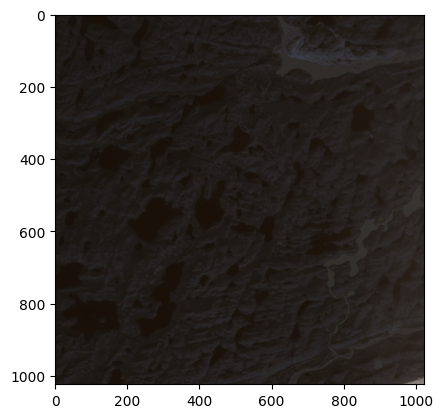

dict_keys(['crs', 'bbox', 'path', 'img_shape', 'input_shape', 'image'])

/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210729.tif
torch.Size([3, 1024, 1024])
tensor(8208.) tensor(8208.)
tensor(209.3040) tensor(10.5060)
(1024, 1024, 3)


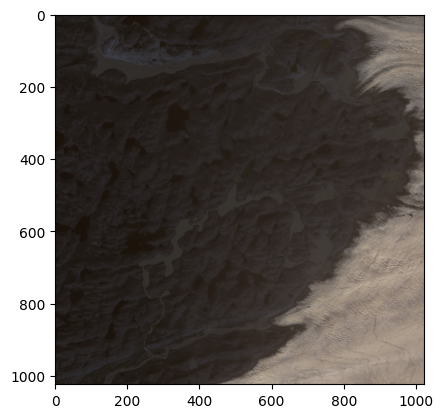

dict_keys(['crs', 'bbox', 'path', 'img_shape', 'input_shape', 'image'])

/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210729.tif
torch.Size([3, 1024, 1024])
tensor(8208.) tensor(8208.)
tensor(209.3040) tensor(21.0375)
(1024, 1024, 3)


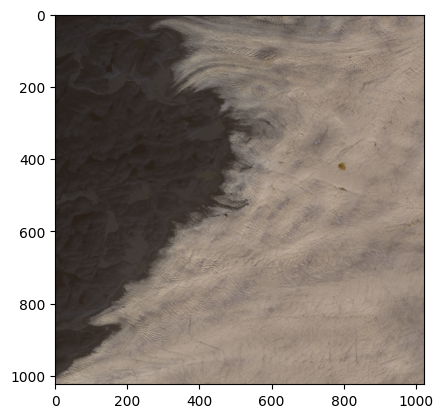

dict_keys(['crs', 'bbox', 'path', 'img_shape', 'input_shape', 'image'])

/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210729.tif
torch.Size([3, 1024, 1024])
tensor(8122.) tensor(8122.)
tensor(207.1110) tensor(29.9115)
(1024, 1024, 3)


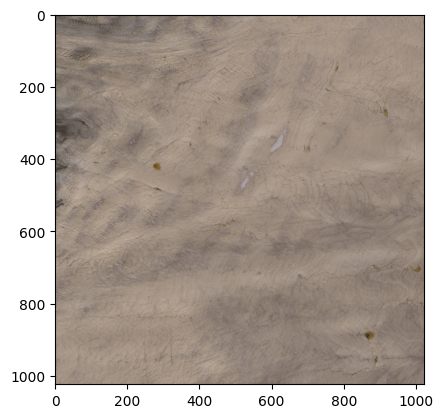

dict_keys(['crs', 'bbox', 'path', 'img_shape', 'input_shape', 'image'])

/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210729.tif
torch.Size([3, 1024, 1024])
tensor(7640.) tensor(7640.)
tensor(194.8200) tensor(29.9115)
(1024, 1024, 3)


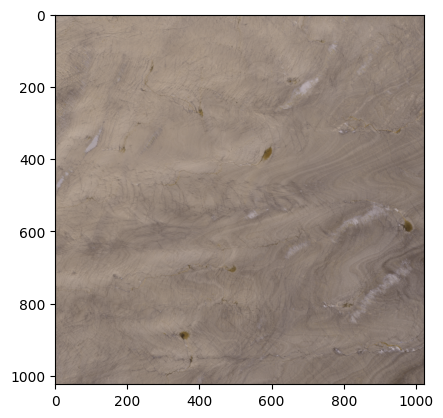

dict_keys(['crs', 'bbox', 'path', 'img_shape', 'input_shape', 'image'])

/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210729.tif
torch.Size([3, 1024, 1024])
tensor(8366.) tensor(8366.)
tensor(213.3330) tensor(19.5585)
(1024, 1024, 3)


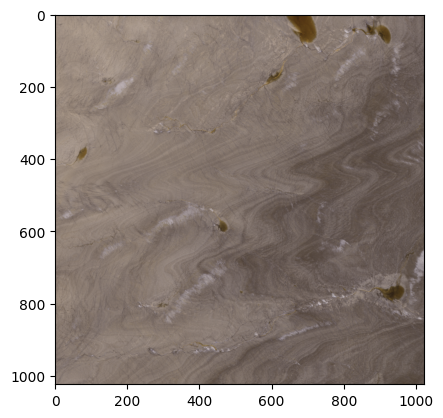

In [46]:
i = 0
i_jump = np.random.randint(len(test_sampler)-5)
for query in test_sampler:
    i = i+1
    if i>i_jump:
        sample = test_imgs[query]
        display(sample.keys())
        print(sample['path'])
        print(sample['image'].shape)
        print(sample['image'].max(), sample['image'].max())
        rds_img = rescale_img(sample['image'], range_max, range_min)
        print(rds_img.max(), rds_img.min())
        raster_img = np.transpose(rds_img.numpy(), (1, 2 ,0))
        print(raster_img.shape)
        plt.imshow(raster_img.astype(np.uint8))
        plt.show()
    if i > i_jump+5:
        break

## Data Loader

In [47]:
test_dataloader = DataLoader(test_imgs, batch_size=16, sampler=test_sampler, collate_fn=stack_samples) # 

for batch in test_dataloader:
    print(batch.keys())
    print(batch['image'].shape)
    display(batch['path'])
    # display(batch['bbox'])
    display(len(batch['image']))
    break

dict_keys(['crs', 'bbox', 'path', 'img_shape', 'input_shape', 'image'])
torch.Size([16, 3, 1024, 1024])


['/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.tif',
 '/DATA/DATA2/joey/sam_data/rasters/greenland/image/20210823.t

16

## Initialize sam predictor

In [33]:

sam_checkpoint = "../sam_dev/checkpoint/sam_vit_h_4b8939.pth"
model_type = "vit_h"
cuda_id = 0

sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
if torch.cuda.is_available():
    if cuda_id + 1 > torch.cuda.device_count():
        cuda_id = torch.cuda.device_count() - 1
    cuda_device = f'cuda:{cuda_id}'
    sam_model.to(device=cuda_device)

In [34]:

@torch.no_grad()
def get_sam_feature(model, batch_input) -> np.ndarray:
    batch_input = batch_input.to(device=sam_model.device)
    batch_input = (batch_input - model.pixel_mean) / model.pixel_std
    features = model.image_encoder(batch_input)
    return features.cpu().numpy()


## Compute features and save as tif

In [35]:
def save_sam_feature(
    raster_ds: SamTestRasterDataset,
    export_dir: Path,
    data_batch: Tensor,
    feature: np.ndarray,
    extent: BoundingBox,
    patch_count: int,
    model_type: str = "vit_h"
) -> int:
    # iterate over batch_size dimension
    for idx in range(feature.shape[-4]):
        band_num = feature.shape[-3]
        height = feature.shape[-2]
        width = feature.shape[-1]
        bbox = data_batch['bbox'][idx]
        rio_transform = rasterio.transform.from_bounds(
            bbox.minx, bbox.miny, bbox.maxx, bbox.maxy, width, height)  # west, south, east, north, width, height
        filepath = Path(data_batch['path'][idx])
        bbox_list = [bbox.minx, bbox.miny, bbox.maxx, bbox.maxy]
        bbox_str = '_'.join(map("{:.6f}".format, bbox_list))
        extent_list = [extent.minx, extent.miny, extent.maxx, extent.maxy]
        extent_str = '_'.join(
            map("{:.6f}".format, extent_list)) + f"_res_{raster_ds.res:.6f}"
        #  Unicode-objects must be encoded before hashing with hashlib and
        #  because strings in Python 3 are Unicode by default (unlike Python 2),
        #  you'll need to encode the string using the .encode method.
        bbox_hash = hashlib.sha256(bbox_str.encode("utf-8")).hexdigest()
        extent_hash = hashlib.sha256(
            extent_str.encode("utf-8")).hexdigest()

        bands_str = '_'.join([str(band) for band in raster_ds.band_indexes])
        export_dir_sub = (export_dir / filepath.stem /
                            f"sam_feat_{model_type}_bands_{bands_str}_{extent_hash[0:16]}")
        export_dir_sub.mkdir(parents=True, exist_ok=True)
        feature_tiff = (export_dir_sub /
                        f"sam_feat_{model_type}_{bbox_hash}.tif")
        feature_csv = (export_dir_sub / f"{export_dir_sub.name}.csv")
        with rasterio.open(
                feature_tiff,
                mode="w",
                driver="GTiff",
                height=height, width=width,
                count=band_num,
                dtype='float32',
                crs=data_batch['crs'][idx],
                transform=rio_transform
        ) as feature_dataset:
            # index start from 1, feature[idx, :, :, :] = feature[idx, ...], later is faster
            feature_dataset.write(feature[idx, ...], range(1, band_num+1))
            # pr_mask_dataset.set_band_description(1, '')
            tags = {
                "img_shape": data_batch["img_shape"][idx],
                "input_shape": data_batch["input_shape"][idx],
                "model_type": model_type,
            }
            feature_dataset.update_tags(**tags)
            feature_res = feature_dataset.res[0]
            feature_crs = feature_dataset.crs

        index_df = pd.DataFrame(columns=['minx', 'maxx', 'miny', 'maxy', 'mint', 'maxt',
                                            'filepath',
                                            'crs', 'res'],
                                index=[patch_count])
        index_df['filepath'] = [feature_tiff.name]
        index_df['minx'] = [bbox.minx]
        index_df['maxx'] = [bbox.maxx]
        index_df['miny'] = [bbox.miny]
        index_df['maxy'] = [bbox.maxy]
        index_df['mint'] = [bbox.mint]
        index_df['maxt'] = [bbox.maxt]
        index_df['crs'] = [str(feature_crs)]
        index_df['res'] = [raster_ds.res]
        index_df['model_type'] = [model_type]
        # append data frame to CSV file, index=False
        index_df.to_csv(feature_csv, mode='a',
                        header=not feature_csv.exists(), index=True)
        patch_count += 1

    return patch_count


In [48]:
from tqdm import tqdm
export_dir = Path('/DATA/DATA2/joey/sam_data/features/')
patch_count = 0
for batch in tqdm(test_dataloader):
    # print(batch.keys())
    # print(batch['image'].shape)
    # display(batch['path'])
    # display(batch['bbox'])
    # display(batch_input.shape)
    batch_input = rescale_img(batch_input=batch['image'], range_max=range_max, range_min=range_min)
    features = get_sam_feature(sam_model, batch_input)
    # display(features.shape)
    patch_count = save_sam_feature(test_imgs, export_dir, batch, features, ROI, patch_count, model_type='vit_h')

    # break
torch.cuda.empty_cache()

  0%|          | 0/160 [00:00<?, ?it/s]

100%|██████████| 160/160 [23:15<00:00,  8.72s/it]
